## Описание проекта

### 🎯 Задача

Построить модель, способную прогнозировать количество заказов такси на следующий час.

> 📌 Целевая метрика: **RMSE**  
> 🎯 Требование: значение **RMSE** на тестовой выборке должно быть **не больше 48**.

Исходные данные находятся в файле `taxi.csv`.  
Целевой признак — `num_orders` (*number of orders*, «число заказов»).

---

### 📚 Содержание

#### Подготовка
- 1.1 Чтение данных
- 1.2 Выводы по разделу

#### Анализ
- 2.1 Обзор данных
- 2.2 Выводы по разделу

#### Обучение
- 3.1 Создание новых признаков
- 3.2 Подготовка данных
- 3.3 Обучение моделей
  - 3.3.1 Дамми-модель
  - 3.3.2 Линейные модели
  - 3.3.3 Бустинговые модели
  - 3.3.4 Нейронная сеть
  - 3.3.5 Анализ остатков лучшей модели
  - 3.3.6 Обучение модели на данных с лагами
- 3.4 Выводы по разделу

#### Тестирование
- 4.1 Инференс
- 4.2 Выводы по разделу

---

### 🧾 Итоговый вывод

В ходе проекта была успешно решена задача прогнозирования количества заказов такси на следующий час.

---

#### 📌 Ключевые итоги:

- Проведен **анализ временного ряда**, выявлены:
  - Явный **тренд** (рост количества заказов со временем)
  - Четкая **суточная и недельная сезонность**
  - Признаки **нестационарности** и **автокорреляции**

- Проведено **обучение моделей** в два этапа:
  1. На данных с календарными признаками  
  2. С добавлением **лаговых признаков**, обоснованных анализом автокорреляции

- Использованы и сравнены различные модели:
  - 📉 **Линейные модели** (Linear, Ridge, Lasso, ElasticNet)
  - 🌳 **Бустинг** (LightGBM)
  - 🧠 **Нейронная сеть**
  - 🎲 **Дамми модель** — как отправная точка

- **ElasticNet** на лаговых признаках показала наилучшее качество:
  - ✅ **RMSE на валидации: ~21.35**
  - ✅ **RMSE на тесте: 35**
  - Обе метрики значительно лучше порогового значения **48**

---

#### ✅ Цель проекта достигнута:

Модель успешно предсказывает спрос на такси с ошибкой **RMSE < 48**.  
Лучшая модель — **ElasticNet с лаговыми признаками** — не только точна, но и интерпретируема.

---

#### 📌 Возможные улучшения:

- Учёт погодных условий, праздников и мероприятий
- Учет внешних факторов (например, пробки, стоимость поездки)
- Более глубокий анализ выбросов и гетероскедастичности
- Расширение и регулярное обновление данных

##  Импорт бибилиотек

In [1]:
#!pip install -U scikit-learn -q

In [2]:
import pandas as pd
import numpy as np
import time
import random
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import (
    train_test_split,
    RandomizedSearchCV
)
from sklearn.model_selection import TimeSeriesSplit

from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    MinMaxScaler,
    RobustScaler
)

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import (
    LinearRegression, 
    Ridge, 
    Lasso,
    ElasticNet
)
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
import torch 
import torch.nn as nn


from math import ceil

from sklearn.model_selection import ParameterSampler
from scipy.stats import uniform, loguniform

from sklearn.metrics import mean_squared_error

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
seed = 42

## Подготовка

### Чтение даных

In [3]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', parse_dates=[0], index_col=[0])
df.sort_index(inplace=True)
df_hour = df.resample('1H').sum()
df_day = df.resample('1D').sum()
df_hour, df_day

C:\Users\Vladimir\AppData\Local\Temp\ipykernel_17164\975567216.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hour = df.resample('1H').sum()


(                     num_orders
 datetime                       
 2018-03-01 00:00:00         124
 2018-03-01 01:00:00          85
 2018-03-01 02:00:00          71
 2018-03-01 03:00:00          66
 2018-03-01 04:00:00          43
 ...                         ...
 2018-08-31 19:00:00         136
 2018-08-31 20:00:00         154
 2018-08-31 21:00:00         159
 2018-08-31 22:00:00         223
 2018-08-31 23:00:00         205
 
 [4416 rows x 1 columns],
             num_orders
 datetime              
 2018-03-01        1364
 2018-03-02        1506
 2018-03-03        1290
 2018-03-04        1141
 2018-03-05        1259
 ...                ...
 2018-08-27        3936
 2018-08-28        3357
 2018-08-29        3762
 2018-08-30        4090
 2018-08-31        4018
 
 [184 rows x 1 columns])

### Выводы по разделу

Данные соответствуют описанию: информация о количестве поездок представленны за период с 01.03 по 31.08.2018 года 10-и минутным интервалом.

В соответствии с заданием длина интеравала преобразована в 1 час, аггрегирующая функция - сумма.

## Анализ

### Обзор данных

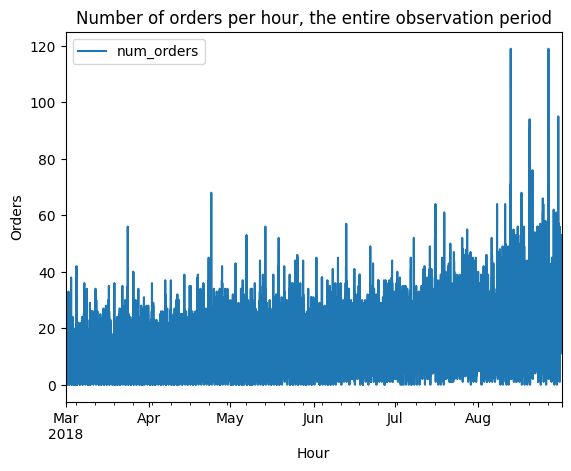

In [4]:
df.plot()
plt.title('Number of orders per hour, the entire observation period')
plt.ylabel('Orders')
plt.xlabel('Hour');

Из графика можно выделить то, что количество заказов в летний период больше чем в весенний что, вероятно, связано с сезоном отпусков. По мере роста среднего количества заказов также растет дисперсия, что говорит нам о том, что ряд нестационарен.

**Анализ тренда, сезонности и остатков**

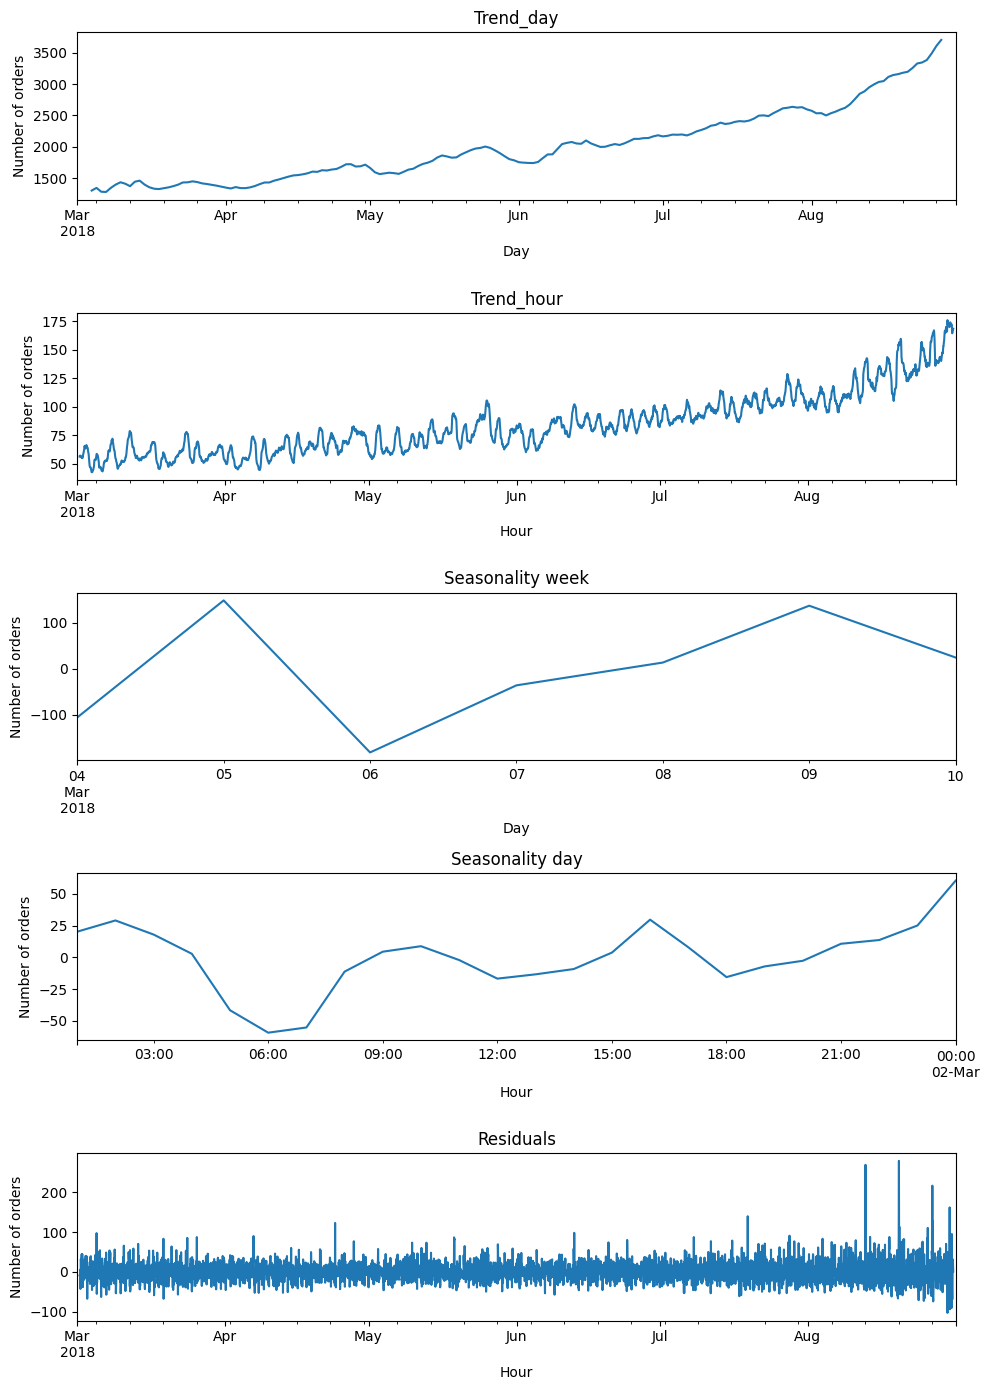

In [5]:
# тренд, сезонность, остатки
decomposed_hour = seasonal_decompose(df_hour)
decomposed_day = seasonal_decompose(df_day)

# строим графики
plt.figure(figsize=(10, 14))

plt.subplot(511)
decomposed_day.trend.plot(ax=plt.gca())
plt.title('Trend_day')
plt.ylabel('Number of orders')
plt.xlabel('Day')

plt.subplot(512)
decomposed_hour.trend.plot(ax=plt.gca())
plt.title('Trend_hour')
plt.ylabel('Number of orders')
plt.xlabel('Hour')

plt.subplot(513)
decomposed_day.seasonal[3:10].plot(ax=plt.gca())
plt.title('Seasonality week')
plt.ylabel('Number of orders')
plt.xlabel('Day')

plt.subplot(514)
decomposed_hour.seasonal[1:25].plot(ax=plt.gca())
plt.title('Seasonality day')
plt.ylabel('Number of orders')
plt.xlabel('Hour')

plt.subplot(515)
decomposed_hour.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.ylabel('Number of orders')
plt.xlabel('Hour')

plt.tight_layout()

В данных наблюдается восходящий **тренд** на протяжении всего периода. 

В данным можно выделить суточную и недельную **сезонности**, которые подозрительно одинаковые на протяжении всего периода наблюдений. Для суточной сезонности, еСли брать за точку отсчета 6 часов утра, то вплоть до 2 часов ночи следующего дня наблюдается восходящий тренд с парой просадок в 12 и в 18 часов. В период с 2 до 6 утра наблюдается сильное снижение количества поездок. Для недельной сезонности свойсвенны всплески спроса по вторникам и субботам, а среда день с самым низким количеством заказов.

В общем остатки выглядят как белый шум (т.е. хорошо), однако в конце периода наблюдаются выбросы и увеличение дисперсии.

### Выводы по разделу

Ряд не стационарен с выраженным восходящим трендом и суточной сезонностью.

## Обучение

К обучению подойдем итеративно: обучим модели на данных с календарными признаками, после чего проанализируем остатки и, по необходимости, добавим лаговые признаки.
Исследуем модели линейной регрессии, бустинговые модели и нейронную сеть. В качестве отправной точки возьмем результаты Дамми модели.

### Создание новых признаков

**Генерирование новых признаков**

In [6]:
def feature_maker(data, lags=None, windows=None):
    # календарные признаки
    data['hour'] = data.index.hour
    data['day'] = data.index.day
    data['day_of_week'] = data.index.dayofweek
    data['is_weekend'] = data['day_of_week'].isin([5, 6]).astype(int)

    # тренд
    data[f'trend_24h'] = data['num_orders'].shift().rolling(24).mean()

    # сезонность
    data['hour_sin'] = np.sin(2 * np.pi * data['hour'] / 24)
    data['hour_cos'] = np.cos(2 * np.pi * data['hour'] / 24)
    
    data['dow_sin'] = np.sin(2 * np.pi * data['day_of_week'] / 7)
    data['dow_cos'] = np.cos(2 * np.pi * data['day_of_week'] / 7)

    # лаги
    if lags:
        for lag in lags:
            data[f'lag_{lag}'] = data['num_orders'].shift(lag)

In [7]:
feature_maker(df_hour)
df_hour

,num_orders,hour,day,day_of_week,is_weekend,trend_24h,hour_sin,hour_cos,dow_sin,dow_cos
datetime,,,,,,,,,,
2018-03-01 00:00:00,124,0,1,3,0,NaN,0.000000,1.000000,0.433884,-0.900969
2018-03-01 01:00:00,85,1,1,3,0,NaN,0.258819,0.965926,0.433884,-0.900969
2018-03-01 02:00:00,71,2,1,3,0,NaN,0.500000,0.866025,0.433884,-0.900969
2018-03-01 03:00:00,66,3,1,3,0,NaN,0.707107,0.707107,0.433884,-0.900969
2018-03-01 04:00:00,43,4,1,3,0,NaN,0.866025,0.500000,0.433884,-0.900969
...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,19,31,4,0,164.875000,-0.965926,0.258819,-0.433884,-0.900969
2018-08-31 20:00:00,154,20,31,4,0,167.541667,-0.866025,0.500000,-0.433884,-0.900969
2018-08-31 21:00:00,159,21,31,4,0,168.041667,-0.707107,0.707107,-0.433884,-0.900969


### Подготовка данных

In [8]:
train, test = train_test_split(df_hour, shuffle=False, test_size=0.1)
train, val = train_test_split(train, shuffle=False, test_size=0.1)
train = train.dropna()

X_train = train.drop([
    'num_orders'
], axis=1).reset_index(drop=True)

X_val = val.drop([
    'num_orders'
], axis=1).reset_index(drop=True)


X_test = test.drop([
    'num_orders'
], axis=1).reset_index(drop=True)


y_train = train['num_orders']
y_val = val['num_orders']
y_test = test['num_orders']

num_cols = X_train.select_dtypes(include='number').columns


# кроссвалидация
tscv = TimeSeriesSplit(n_splits=3)

X_train.shape, X_val.shape, X_test.shape

((3552, 9), (398, 9), (442, 9))

In [9]:
best_models = {}
total_results = pd.DataFrame(columns=[
    'Model', 
    'RMSE_train',
    'Train_time'
])

### Обучение моделей

#### Дамми модель

In [10]:
def train_dummy(X_train, y_train, X_test, y_test, model_num, strategy='mean', name='Dummy'):
    global total_results

    # Масштабирование
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Инициализация и обучение
    dummy = DummyRegressor(strategy=strategy)
    start_time = time.time()
    dummy.fit(X_train, y_train)
    train_time = time.time() - start_time

    # Предсказание
    start_pred = time.time()
    preds = dummy.predict(X_test)
    inf_time = time.time() - start_pred

    # Метрики
    rmse_tr = np.sqrt(mean_squared_error(y_train, dummy.predict(X_train)))
    rmse_te = np.sqrt(mean_squared_error(y_test, dummy.predict(X_test)))

    # Сохраняем
    new_row = pd.DataFrame([{
        'Model': f'{name}_{model_num}',
        'RMSE_train': round(rmse_tr, 2),
        'Train_time': round(train_time, 3)
    }])

    total_results = pd.concat([total_results, new_row], ignore_index=True)

In [11]:
model_num = 1

train_dummy(
    X_train,
    y_train,
    X_test,
    y_test,
    model_num,
    strategy='mean',
    name='Dummy_mean'
)

total_results

C:\Users\Vladimir\AppData\Local\Temp\ipykernel_17164\3624133899.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  total_results = pd.concat([total_results, new_row], ignore_index=True)


,Model,RMSE_train,Train_time
0,Dummy_mean_1,36.0,0.002


#### Линейные модели

In [12]:
# Пайплайн
# Пайплайн для числовых признаков
lr_num_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

# Общий препроцессор
lr_preprocessor = ColumnTransformer([
    ('num', lr_num_pipeline, num_cols)
], remainder='passthrough')

# Финальный pipeline
lr_pipe_final = Pipeline([
    ('preprocessor', lr_preprocessor),
    ('models', 'passthrough')
])

In [13]:
# Сетка гиперпараметров
lr_rs_grid = {
    'Linear': {
        'models': [LinearRegression()]
    },
    'Ridge': {
        'models': [Ridge(max_iter=3000, random_state=seed)],
        'models__alpha': np.logspace(-3, 2, 10), 
    },
    'Lasso': {
        'models': [Lasso(max_iter=3000, random_state=seed)],
        'models__alpha': np.logspace(-3, 2, 10),
    },
    'ElasticNet': {
        'models': [ElasticNet(max_iter=3000, random_state=seed)],
        'models__alpha': np.logspace(-3, 2, 10),
        'models__l1_ratio': np.linspace(0.1, 0.9, 5),
    },
}

In [14]:
# Обучение моделей
def train_linear(X_train, y_train, pipeline, grid, model_num):
    global best_models, total_results
    
    for model_name, g in grid.items():
        rs = RandomizedSearchCV(
            pipeline,
            param_distributions=g,
            scoring='neg_root_mean_squared_error',
            n_jobs=-1,
            n_iter=3,
            cv=tscv,
            verbose=1,
            random_state=seed
        )

        rs.fit(X_train, y_train)

        # Сохранение лучшей модели
        best_models[f'{model_name}_{model_num}'] = rs.best_estimator_

        # Сохраняем
        new_row = pd.DataFrame([{
            'Model': f'{model_name}_{model_num}',
            'RMSE_train': round(-rs.best_score_, 2),
            'Train_time': round(rs.cv_results_['mean_fit_time'][rs.best_index_], 2)
        }])

        total_results = pd.concat([total_results, new_row], ignore_index=True)

In [15]:
train_linear(
    X_train,
    y_train,
    lr_pipe_final,
    lr_rs_grid,
    model_num
)


total_results.sort_values(by='RMSE_train')

C:\Users\Vladimir\anaconda3\envs\practicum\lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 1 is smaller than n_iter=3. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Fitting 3 folds for each of 3 candidates, totalling 9 fits


,Model,RMSE_train,Train_time
1,Linear_1,31.09,0.030
2,Ridge_1,31.09,0.020
3,Lasso_1,31.10,0.020
4,ElasticNet_1,31.14,0.020
0,Dummy_mean_1,36.00,0.002


#### Бустинговые модели

In [16]:
# Пайплайн
b_pipe_final = Pipeline([
    ('models', CatBoostClassifier(verbose=0))
])

In [17]:
# Сетка гиперпараметров
b_rs_grid = {
    'LGBMClassifier': {
        'models': [LGBMClassifier(
            n_estimators=200,
            random_state=seed)],
        'models__num_leaves': [7, 15],
        'models__learning_rate': [0.03, 0.1],
    }
}

In [18]:
# Обучение моделей
def train_boosting(X_train, y_train, pipeline, grid, model_num):
    global best_models, total_results

    for model_name, g in grid.items():
        rs = RandomizedSearchCV(
            pipeline,
            param_distributions=g,
            scoring='neg_root_mean_squared_error',
            n_jobs=-1,
            n_iter=3,
            cv=tscv,
            verbose=1,
            random_state=seed
        )

        rs.fit(X_train, y_train)

        best_models[f'{model_name}_{model_num}'] = rs.best_estimator_

        new_row = pd.DataFrame([{
            'Model': f'{model_name}_{model_num}',
            'RMSE_train': round(-rs.best_score_, 2),
            'Train_time': round(rs.cv_results_['mean_fit_time'][rs.best_index_], 2)
        }])

        total_results = pd.concat([total_results, new_row], ignore_index=True)

In [19]:
train_boosting(
    X_train,
    y_train,
    b_pipe_final,
    b_rs_grid,
    model_num
)


total_results.sort_values(by='RMSE_train')

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000272 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 373
[LightGBM] [Info] Number of data points in the train set: 3552, number of used features: 9
[LightGBM] [Info] Start training from score -8.175266
[LightGBM] [Info] Start training from score -7.076654
[LightGBM] [Info] Start training from score -6.383507
[LightGBM] [Info] Start training from score -6.565828
[LightGBM] [Info] Start training from score -6.565828
[LightGBM] [Info] Start training from score -5.872681
[LightGBM] [Info] Start training from score -5.690359
[LightGBM] [Info] Start training from score -5.467216
[LightGBM] [Info] Start training from score -6.565828
[LightGBM] [Info] Start training from score -6.095825
[LightGBM] [Info] Start training from score -6.2293

,Model,RMSE_train,Train_time
1,Linear_1,31.09,0.030
2,Ridge_1,31.09,0.020
3,Lasso_1,31.10,0.020
4,ElasticNet_1,31.14,0.020
5,LGBMClassifier_1,33.35,22.470
0,Dummy_mean_1,36.00,0.002


#### Нейронная сеть

In [20]:
# вводные
num_epochs = 2000
loss_fn = nn.MSELoss()

def kaiming_uni(layer):
    if type(layer) == nn.Linear:
        nn.init.kaiming_uniform_(layer.weight, mode='fan_in', nonlinearity='relu')

In [21]:
class Net13(nn.Module):
    def __init__(self, input_dim, middle_dim, dropout=0.5):
        super(Net13, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, middle_dim),
            nn.Dropout(p=dropout),
            nn.ReLU(),
            nn.Linear(middle_dim, 1)
        )
        self.net.apply(kaiming_uni)

    def forward(self, x):
        return self.net(x)

In [22]:
# Сетка гиперпарамтеров
param_distributions = {
    'dropout': uniform(0.2, 0.6),               # от 0.2 до 0.7
    'lr': loguniform(1e-4, 1e-2),               # [0.0001, 0.01]          
}

samples = list(ParameterSampler(param_distributions, n_iter=5, random_state=seed))

In [23]:
def train_full_batch_cv(
    net_factory, X_df, y, loss_fn, sample, model_num, n_splits=5, num_epochs=1000, patience=500,
    seed=seed, num=1, modelsss=None, resss=None, trans=None
):
    tscv = TimeSeriesSplit(n_splits=n_splits)

    rmse_list = []
    train_time_list = []

    for fold, (train_idx, val_idx) in enumerate(tscv.split(X_df)):
        print(f'\n📅 Fold {fold+1}/{n_splits}')

        X_train = X_df.iloc[train_idx]
        X_val = X_df.iloc[val_idx]
        y_train = y.iloc[train_idx]
        y_val = y.iloc[val_idx]

        # --- Преобразование ---
        std_nn = StandardScaler()
        
        X_train_scaled = std_nn.fit_transform(X_train)
        X_val_scaled = std_nn.transform(X_val)          
            
        X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
        X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
        y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).unsqueeze(1)

        # --- Модель ---
        input_dim = X_train_tensor.shape[1]
        middle_dim = round(input_dim / 2)
        model = net_factory(input_dim, middle_dim, sample['dropout'])
        optimizer = torch.optim.Adam(model.parameters(), lr=sample['lr'])

        best_loss = float('inf')
        no_improve = 0
        start_time = time.time()

        for epoch in range(num_epochs):
            model.train()
            y_pred = model(X_train_tensor)
            loss = loss_fn(y_pred, y_train_tensor)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            model.eval()
            with torch.no_grad():
                val_pred = model(X_val_tensor)
                val_loss = loss_fn(val_pred, y_val_tensor)

            if val_loss.item() < best_loss:
                best_loss = val_loss.item()
                no_improve = 0
            else:
                no_improve += 1

            if no_improve >= patience:
                print(f'  🚦 Early stopped at epoch {epoch}')
                break

        duration = round(time.time() - start_time, 2)

        val_rmse = round(np.sqrt(mean_squared_error(y_val_tensor, val_pred)), 2)
        print(f'✅ Fold {fold+1} RMSE: {val_rmse}')

        rmse_list.append(val_rmse)
        train_time_list.append(duration)

    # --- Усреднение ---
    mean_rmse = round(np.mean(rmse_list), 4)
    total_train_time = round(np.sum(train_time_list), 2)

    print(f'\n📊 AVG RMSE: {mean_rmse}, TOTAL TRAIN TIME: {total_train_time} sec')

    # --- Сохраняем только финальный результат и финальную модель ---
    modelsss[f'nn_{num}_{model_num}'] = model
    resss[f'nn_{num}_{model_num}'] = {
        'RMSE': mean_rmse,
        'Train_time': total_train_time
    }
    trans[f'std'] = std_nn
    
    return mean_rmse, total_train_time

In [24]:
def train_neural_nets_batch(net_class, X_train, y_train, loss_fn,
    samples, model_num, num_epochs, patience, n_splits, seed):
    global best_models, total_results
    
    modelsss = {}
    resss = {}
    trans = {}
    num = 0

    for i, sample in enumerate(samples):
        num += 1
        print(f"\n🔁 Config {i+1}/{len(samples)}: {sample}")

        train_full_batch_cv(
            net_class,
            X_train,
            y_train,
            loss_fn,
            sample,
            model_num,
            num_epochs=num_epochs,
            patience=patience,
            n_splits=n_splits,
            seed=seed,
            num=num,
            modelsss=modelsss,
            resss=resss,
            trans=trans
        )

    # --- Сохраняем результат лучшей модели ---
    row = pd.DataFrame(resss).T.sort_values('RMSE').reset_index().iloc[0]
    nn_row = {
        "Model": row['index'],
        "RMSE_train": row['RMSE'],
        "Train_time": row['Train_time']
    }
    total_results = pd.concat([total_results, pd.DataFrame([nn_row])], ignore_index=True)
    best_m_name = row['index']
    best_models[best_m_name] = modelsss[best_m_name]

In [25]:
train_neural_nets_batch(
    Net13,
    X_train,
    y_train,
    loss_fn,
    samples,
    model_num,
    num_epochs=num_epochs,
    patience=200,
    n_splits=3,
    seed=seed
)

total_results.sort_values('RMSE_train')


🔁 Config 1/5: {'dropout': np.float64(0.4247240713084175), 'lr': np.float64(0.007969454818643935)}

📅 Fold 1/3
  🚦 Early stopped at epoch 1419
✅ Fold 1 RMSE: 37.0

📅 Fold 2/3
  🚦 Early stopped at epoch 1644
✅ Fold 2 RMSE: 35.24

📅 Fold 3/3
  🚦 Early stopped at epoch 720
✅ Fold 3 RMSE: 42.65

📊 AVG RMSE: 38.2967, TOTAL TRAIN TIME: 9.61 sec

🔁 Config 2/5: {'dropout': np.float64(0.6391963650868431), 'lr': np.float64(0.0015751320499779737)}

📅 Fold 1/3
✅ Fold 1 RMSE: 50.27

📅 Fold 2/3
✅ Fold 2 RMSE: 65.21

📅 Fold 3/3
  🚦 Early stopped at epoch 1724
✅ Fold 3 RMSE: 58.5

📊 AVG RMSE: 57.9933, TOTAL TRAIN TIME: 12.91 sec

🔁 Config 3/5: {'dropout': np.float64(0.2936111842654619), 'lr': np.float64(0.00020511104188433984)}

📅 Fold 1/3
✅ Fold 1 RMSE: 72.16

📅 Fold 2/3
✅ Fold 2 RMSE: 79.4

📅 Fold 3/3
✅ Fold 3 RMSE: 97.21

📊 AVG RMSE: 82.9233, TOTAL TRAIN TIME: 13.19 sec

🔁 Config 4/5: {'dropout': np.float64(0.23485016730091968), 'lr': np.float64(0.005399484409787433)}

📅 Fold 1/3
✅ Fold 1 RMSE: 30.

,Model,RMSE_train,Train_time
1,Linear_1,31.0900,0.030
2,Ridge_1,31.0900,0.020
3,Lasso_1,31.1000,0.020
4,ElasticNet_1,31.1400,0.020
5,LGBMClassifier_1,33.3500,22.470
6,nn_4_1,33.8933,10.590
0,Dummy_mean_1,36.0000,0.002


Лучший результат показали линейные модели, как по качесву так и по времени обучения. Лучшая - линейная регрессия (Linear_1) со значением метрики 31.

**Функция обучения моделей**

In [26]:
def consolid_train(
    X_train, y_train, X_test, y_test,
    lr_pipe_final, lr_rs_grid,
    b_pipe_final, b_rs_grid,
    Net13, loss_fn, samples, num_epochs, seed,
    model_num):
    
    # Дамми модель
    train_dummy(
        X_train,
        y_train,
        X_test,
        y_test,
        model_num,
        strategy='mean',
        name='Dummy_mean'
    )

    # Линейная регрессия
    train_linear(
        X_train,
        y_train,
        lr_pipe_final,
        lr_rs_grid,
        model_num
    )

    # Бустинг модели
    train_boosting(
        X_train,
        y_train,
        b_pipe_final,
        b_rs_grid,
        model_num
    )

    # Нейронная сеть
    train_neural_nets_batch(
        Net13,
        X_train,
        y_train,
        loss_fn,
        samples,
        model_num,
        num_epochs=num_epochs,
        patience=200,
        n_splits=3,
        seed=seed
    )

#### Анализ остатков лучшей модели

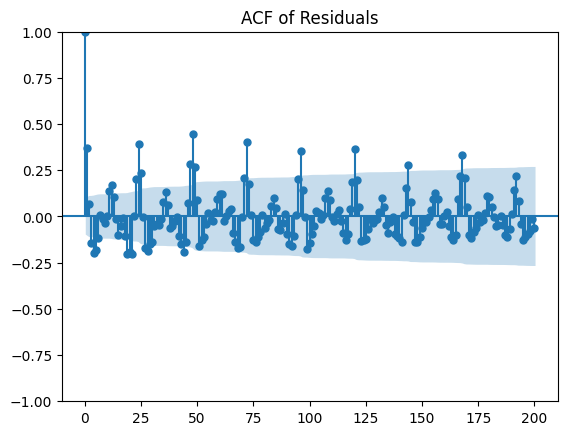

Значимые лаги: [  0   1   3   4   5   6  11  12  13  18  19  20  21  23  24  25  27  28
  29  30  36  42  43  44  45  47  48  49  51  52  53  60  61  67  68  69
  71  72  73  75  76  77  84  91  92  93  95  96  97  99 100 107 108 116
 119 120 121 123 124 125 132 139 140 141 143 144 147 148 149 156 163 164
 165 167 168 169 171 172 179 180 187 188 191 192 195 196]


In [27]:
# Например, на тесте
bm = best_models['Linear_1']
y_pred = bm.predict(X_val)

residuals = y_val - y_pred

# ACF остатков
plot_acf(residuals, lags=200)
plt.title('ACF of Residuals')
plt.show()


# ACF-значения
acf_values = sm.tsa.acf(residuals, nlags=200)

# Значение критического доверительного интервала
# (по умолчанию примерно 95% доверие)
n = len(residuals)
conf_int = 1.96 / np.sqrt(n)

# Найти лаги, которые значимы (за пределами доверительного интервала)
significant_lags = np.where(np.abs(acf_values) > conf_int)[0]

print("Значимые лаги:", significant_lags)
#print("ACF для этих лагов:", acf_values[significant_lags])

Остатки автокоррелированы, значит модель недостаточно хорошо описывает структуру временного ряда. Добавим статистически значимые лаги в данные и обучим новую модель.

**Анализ остатков**

In [28]:
def residuals_analysis(y_true, y_pred):
    df_graph = pd.DataFrame({
        'True': y_true,
        'Pred': y_pred,
        'Residuals': y_true-y_pred
    })
    
    sns.scatterplot(data=df_graph, x='Pred', y='Residuals')
    plt.xlabel('Predicted')
    plt.ylabel('Residuals')
    plt.title('True vs Predicted Scatter Plot')
    plt.show()

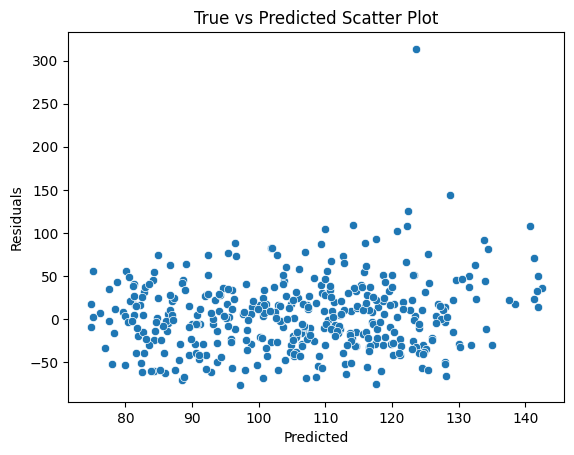

In [29]:
residuals_analysis(y_val, y_pred)

С ростом предсказаного значения растет и дисперсия, что говорит о том, что требуются улучшения. Хотя в общем, большая часть прежсказаний лежат в диапазоне от -75 до 75. Едем дальше

#### Обучение модели на данных с лагами

**Добавление лаговых признаков и разделение тренирвоочную и тестовую выборки**

In [30]:
df_hour_2 = df_hour.copy()
feature_maker(df_hour_2, lags=list(significant_lags[1:]))
df_hour_2.shape

(4416, 95)

In [31]:
train_2, test_2 = train_test_split(df_hour_2, shuffle=False, test_size=0.1)
train_2, val_2 = train_test_split(train_2, shuffle=False, test_size=0.1)
train_2 = train_2.dropna()

X_train_2 = train_2.drop([
    'num_orders'
], axis=1).reset_index(drop=True)

X_val_2 = val_2.drop([
    'num_orders'
], axis=1).reset_index(drop=True)


X_test_2 = test_2.drop([
    'num_orders'
], axis=1).reset_index(drop=True)


y_train_2 = train_2['num_orders']
y_val_2 = val_2['num_orders']
y_test_2 = test_2['num_orders']

num_cols = X_train_2.select_dtypes(include='number').columns


# кроссвалидация
tscv = TimeSeriesSplit(n_splits=3)

X_train_2.shape, X_val_2.shape, X_test_2.shape

((3380, 94), (398, 94), (442, 94))

**Обучение моделей**

In [32]:
model_num = 2

consolid_train(
    X_train_2, y_train_2, X_val_2, y_val_2,
    lr_pipe_final, lr_rs_grid,
    b_pipe_final, b_rs_grid,
    Net13, loss_fn, samples, num_epochs, seed, model_num
)

total_results.sort_values('RMSE_train')

C:\Users\Vladimir\anaconda3\envs\practicum\lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 1 is smaller than n_iter=3. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Fitting 3 folds for each of 3 candidates, totalling 9 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004112 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15231
[LightGBM] [Info] Number of data points in the train set: 3380, number of used features: 94
[LightGBM] [Info] Start training from score -8.125631
[LightGBM] [Info] Start training from score -7.027019
[LightGBM] [Info] Start training from score -6.333872
[LightGBM] [Info] Start training from score -6.739337
[LightGBM] [Info] Start training from score -6.516193
[LightGBM] [Info] Start training from score -5.823046
[LightGBM] [Info] Start training from score -5.823046
[LightGBM] [Info] Start training from 

,Model,RMSE_train,Train_time
11,ElasticNet_2,21.3500,0.090
10,Lasso_2,21.3700,0.040
8,Linear_2,21.4600,0.040
9,Ridge_2,21.4600,0.040
13,nn_1_2,23.3967,10.610
1,Linear_1,31.0900,0.030
12,LGBMClassifier_2,31.0900,75.030
2,Ridge_1,31.0900,0.020
3,Lasso_1,31.1000,0.020
4,ElasticNet_1,31.1400,0.020


В целом, все линейные модели демонстрируют хороший результат со значением целевой метрики в диапазоне от 24.35 до 21.46 (выбирай любую). Рассмотрим лучшую ElasticNet.

**Анализ остатков лучшей модели**

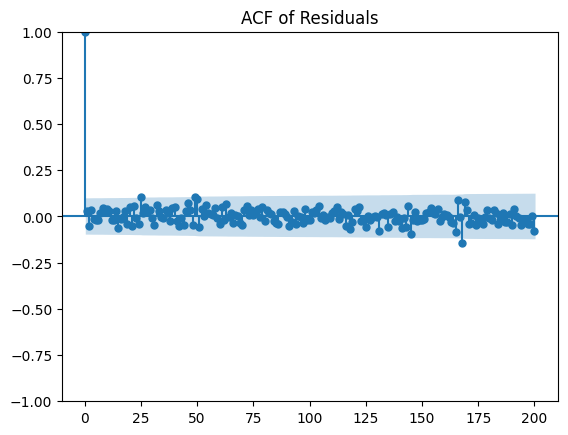

Значимые лаги: [  0  25  49 168]


In [33]:
# Например, на тесте
bm_2 = best_models['ElasticNet_2']
y_pred_2 = bm_2.predict(X_val_2)

residuals_2 = y_val - y_pred_2

# ACF остатков
plot_acf(residuals_2, lags=200)
plt.title('ACF of Residuals')
plt.show()


# ACF-значения
acf_values_2 = sm.tsa.acf(residuals_2, nlags=200)

# Значение критического доверительного интервала
# (по умолчанию примерно 95% доверие)
n_2 = len(residuals_2)
conf_int_2 = 1.96 / np.sqrt(n_2)

# Найти лаги, которые значимы (за пределами доверительного интервала)
significant_lags_2 = np.where(np.abs(acf_values_2) > conf_int_2)[0]

print("Значимые лаги:", significant_lags_2)
#print("ACF для этих лагов:", acf_values_2[significant_lags_2])

Автокорреляция остатков незначительна, значит нет остаточной структуры, требующей улучшения. Далее можно почистить признаки с нулевыми коэффициентами модели (ElasticNet обнуляет ненужные), но это уже в следующей жизни....

### Выводы по разделу

Обучение проходило в 2 этапа, обучение на календарных данных и с добавлением лаговых признаков. Добавленеи лаговых признаков обосновано анализом автокорреляции остатков (на тестовом датасете). В результате были выявлены лаговые признаки позволяющие улучшить значение целевой метриики (RMSE) на ~30% с 31 до 21.35, что существенно превосходит значение бейзлайна - 36 (значением Дамми модели). Были рассмотрены модели линейной регрессии (Linear, Lasso, Ridge, ElasticNet), бустинговая модель (LightGBM) и простенькая полносвязная нейронная сеть (2 слоя, ReLU, kaiming_uniform, MSELoss, Dropout).

Достигнутый результат (RMSE 21.35) позволяет двигаться 

## Тестирование

### Инференс

In [34]:
yp = bm_2.predict(X_test_2)
RMSE_inf = round(np.sqrt(mean_squared_error(yp, y_test)), 4)
print(f'RMSE_inference: {RMSE_inf}')

RMSE_inference: 34.389


**Анализ остатков**

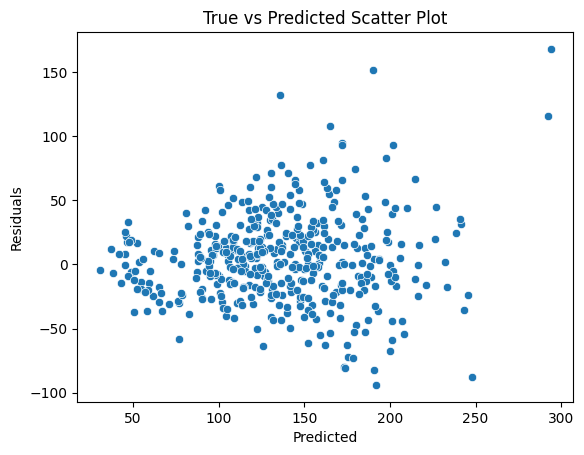

In [35]:
df_graph = pd.DataFrame({
    'True': y_test,
    'Pred': yp,
    'Residuals': y_test-yp
})

sns.scatterplot(data=df_graph, x='Pred', y='Residuals')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('True vs Predicted Scatter Plot')
plt.show()

На лицо непостоянство дисперсии остатков. Требуется доработка модели.

### Выводы по разделу

Значение метрики на тестовом наборе данных составляет 35. Цель достигнута.

## Итоговый вывод

### 🧾 Итоговый вывод

В ходе проекта была успешно решена задача прогнозирования количества заказов такси на следующий час.

---

#### 📌 Ключевые итоги:

- Проведен **анализ временного ряда**, выявлены:
  - Явный **тренд** (рост количества заказов со временем)
  - Четкая **суточная и недельная сезонность**
  - Признаки **нестационарности** и **автокорреляции**

- Проведено **обучение моделей** в два этапа:
  1. На данных с календарными признаками  
  2. С добавлением **лаговых признаков**, обоснованных анализом автокорреляции

- Использованы и сравнены различные модели:
  - 📉 **Линейные модели** (Linear, Ridge, Lasso, ElasticNet)
  - 🌳 **Бустинг** (LightGBM)
  - 🧠 **Нейронная сеть**
  - 🎲 **Дамми модель** — как отправная точка

- **ElasticNet** на лаговых признаках показала наилучшее качество:
  - ✅ **RMSE на валидации: ~21.35**
  - ✅ **RMSE на тесте: 35**
  - Обе метрики значительно лучше порогового значения **48**

---

#### ✅ Цель проекта достигнута:

Модель успешно предсказывает спрос на такси с ошибкой **RMSE < 48**.  
Лучшая модель — **ElasticNet с лаговыми признаками** — не только точна, но и интерпретируема.

---

#### 📌 Возможные улучшения:

- Учёт погодных условий, праздников и мероприятий
- Учет внешних факторов (например, пробки, стоимость поездки)
- Более глубокий анализ выбросов и гетероскедастичности
- Расширение и регулярное обновление данных